In [1]:
import numpy as np 
import pandas as pd
import re 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from re import sub

from tabulate import tabulate
from tqdm import trange 
import random 
import multiprocessing
from sklearn.cluster import KMeans

In [2]:
from time import time 
from unidecode import unidecode
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser

In [3]:
# More Imports 
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

In [4]:
from cleantext import clean

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
tweets = pd.read_csv("elonmusk_2021-11-26.csv", index_col = False)
tweets = tweets.drop(columns="Unnamed: 0")

In [7]:
tweets = tweets.sort_values(by=['Datetime'])


In [8]:
# using clean to remove the emojis from all tweets 
def clean_text(x): 
    x = clean(x, no_emoji=True)
    return x 

def remove_stop_word(text):
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)
    text = text.split()
    word_list = [w for w in text if w not in stop_words] 
    return word_list
        

# tweets.Text = tweets.Text.apply(clean_text)

In [9]:
tweets["Word_List"] = tweets.Text.apply(remove_stop_word)

In [10]:
phrases = Phrases(tweets.Word_List, min_count=1, progress_per=500000)

In [11]:
bigram = Phraser(phrases)

In [12]:
sentences = bigram[tweets.Word_List]

In [13]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

w2v_model.vector_size = 300

start = time()

w2v_model.build_vocab(sentences, progress_per=50000) 

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay = 1)

print("Time to train the model: {} mins".format(round((time() -start)/ 60,2)))

w2v_model.init_sims(replace=True)

Time to train the model: 0.02 mins


C:\Users\bhuwa\AppData\Local\Temp\ipykernel_4448\854251204.py:19: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [14]:
temp = tweets.Word_List
temp.apply(lambda x: ' '.join(bigram[x]))

928                                dropping friends pool
927                                        splish splash
926                                                     
925          dayquil plus nyquil https_//t co/aadssrmjyf
924         blow_whistle tesla ! https_//t co/c86hla0iqk
                             ...                        
4      tesla full self_driving beta available anyone ...
3      might notice small sometimes major improvement...
2      people_spoken amnesty begins next week vox_pop...
1      thanksgiving cuisine delightful symphony flavor !
0                                    think culture war ?
Name: Word_List, Length: 929, dtype: object

In [15]:
word_vectors = w2v_model.wv
model_k = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)
positive_cluster_center = model_k.cluster_centers_[0]
negative_cluster_center = model_k.cluster_centers_[1]

C:\Users\bhuwa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [16]:
model_k.cluster_centers_

array([[-0.01146346,  0.01488798,  0.01693169,  0.00333735, -0.00217718,
        -0.00721252, -0.02699738,  0.01446479, -0.00935097,  0.02400909,
        -0.02089914, -0.03029446,  0.00550795,  0.0205628 , -0.00220107,
         0.0030316 ,  0.00514591, -0.00142077,  0.03283321,  0.01246648,
        -0.00125937, -0.00296437,  0.01708045,  0.00562681, -0.00270615,
         0.01371288,  0.00231122,  0.00459115, -0.00660328,  0.01286782,
         0.01556407, -0.00692473,  0.01921166, -0.00997226, -0.02944162,
        -0.00334534,  0.01559372,  0.00052092,  0.0127546 , -0.00779379,
        -0.00309386,  0.00161669, -0.0188576 , -0.02002946, -0.01632452,
         0.00926724,  0.0009747 , -0.01292452,  0.00811902, -0.01221974,
         0.0118126 , -0.00226348, -0.01311588, -0.00454971,  0.00662278,
         0.00983229, -0.01070018, -0.01124404, -0.03175205,  0.00304037,
        -0.00538012, -0.00520442, -0.01326666,  0.01411611,  0.01959212,
        -0.00337276,  0.02670472, -0.01966602, -0.0

In [17]:
word_vectors.similar_by_vector(model_k.cluster_centers_[0], topn=10, restrict_vocab=None)

[('mention', 0.3219534158706665),
 ('use', 0.30631595849990845),
 ('team_making', 0.3022902309894562),
 ('great', 0.2996186912059784),
 ('tesla_ai', 0.29887640476226807),
 ('tesla_make', 0.2945714592933655),
 ('!', 0.29157179594039917),
 ('friend', 0.28394776582717896),
 ('tweets', 0.28337758779525757),
 ('10', 0.28198903799057007)]

In [18]:
words = pd.DataFrame(list(word_vectors.index_to_key))
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model_k.predict(np.array(x).reshape(1,-1)))

In [56]:
words.cluster 

0      [1]
1      [0]
2      [1]
3      [1]
4      [0]
      ... 
436    [1]
437    [1]
438    [0]
439    [0]
440    [0]
Name: cluster, Length: 441, dtype: object

In [57]:
words['cluster_value'] = [1 if i == 0 else -1 for i in words.cluster]

In [58]:
words['closeness_score'] = words.apply(lambda x: 1/(model_k.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [59]:
punctuation = ["!", "?", ">", "<", "-", ".", ":", "@", "%"]

index_list = []

for item in punctuation:
    if len(words.index[words['words'] == item]) != 0:
        index_list.append(words.index[words["words"] == item][0])
index_list

[1, 4]

In [60]:
word_duplicate = words

In [68]:
# word_duplicate.drop([1,4], axis=0, inplace=True).reset_index()

In [67]:
word_duplicate = word_duplicate.reset_index(drop=True)

In [69]:
word_duplicate.to_csv("word_sentiment_coeff.csv")

## Stock Data

In [85]:
tsla_stock = pd.read_csv('stock_data.csv')
tsla_stock = tsla_stock.rename(columns={"Unnamed: 0": "Date"})

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-26 09:30:00,366.489990,369.594238,360.483307,367.483307,367.483307,4954776
1,2021-11-26 10:30:00,367.560028,368.873291,361.463348,364.391693,364.391693,2401584
2,2021-11-26 11:30:00,364.283325,366.056671,362.670013,363.925018,363.925018,1697599
3,2021-11-26 13:00:00,363.826660,364.323334,360.333344,361.323334,361.323334,0
4,2021-11-29 09:30:00,366.996674,379.829956,366.729980,374.751678,374.751678,6506994
...,...,...,...,...,...,...,...
1753,2022-11-23 15:30:00,183.100006,183.399994,182.529999,183.289993,183.289993,7359730
1754,2022-11-25 09:30:00,185.059998,185.199997,180.630005,183.308197,183.308197,26598363
1755,2022-11-25 10:30:00,183.323502,184.220001,182.050003,182.160004,182.160004,10681828
1756,2022-11-25 11:30:00,182.169998,183.000000,181.949997,182.949997,182.949997,7381549


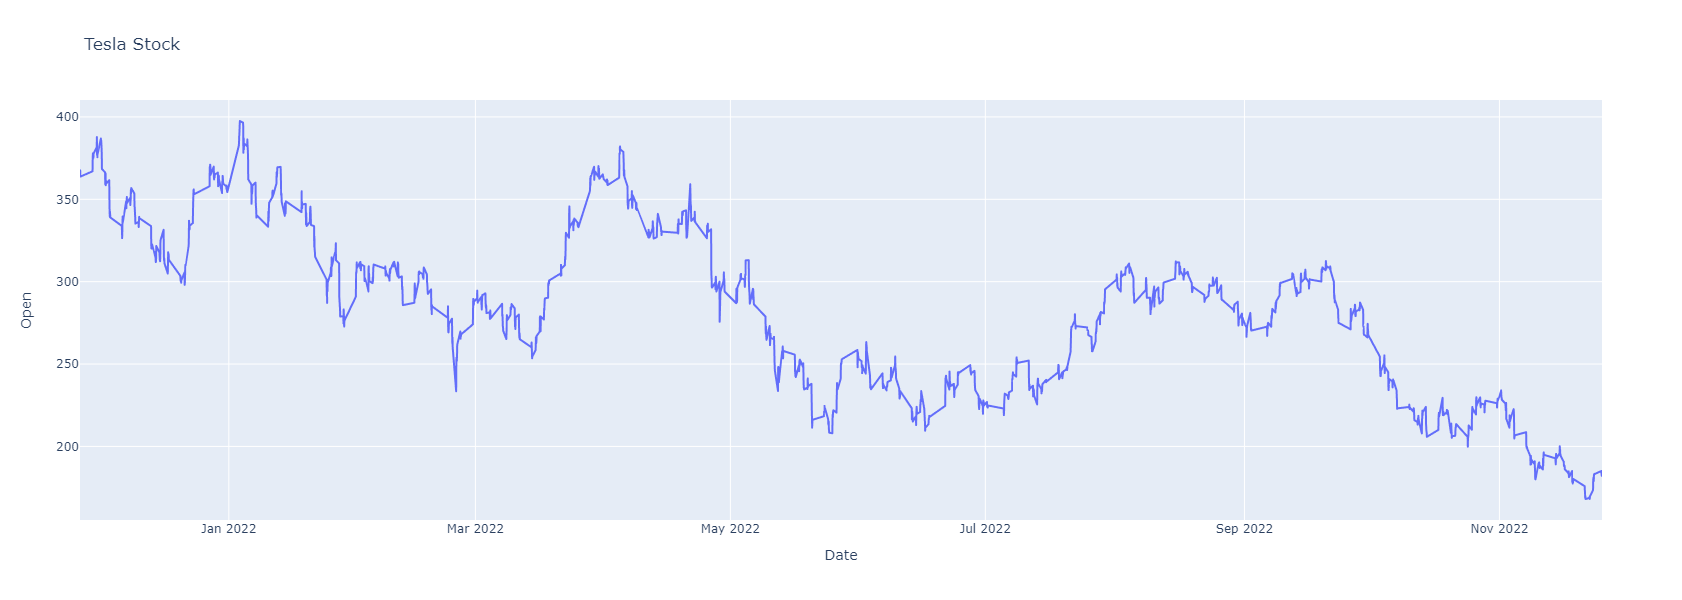

In [103]:
fig = px.line(tsla_stock, x="Date", y="Open", hover_data=["Open", "Close", "Adj Close", "Volume"], title="Tesla Stock", height=600)
fig.show()